In [ ]:
import sys
sys.path.append("./src")

In [1]:
import logging
import os
import warnings

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from classes import NetworkParameters
from dataset import HousingDataset
from learner import HousingModel
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from loss_callback import LossHistory
from network import HousingNetwork
from rich import print
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.utils.data import DataLoader, Dataset
from preprocessing import split_data, run_pipeline, get_column_by_type, label_encode, categorize_house
import optuna
from hparam_tuning import Objective

%load_ext autoreload
%autoreload 2
%load_ext rich

pd.set_option("display.max_columns", None)
seed = torch.manual_seed(42)
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Load data

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [3]:
train["HouseCategory"] = train.apply(categorize_house, axis=1)

house_category_encoder = LabelEncoder()

train["HouseCategory"] = house_category_encoder.fit_transform(train["HouseCategory"])
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HouseCategory
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,8
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,6
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,12
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,12
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,14
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,12
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,T

In [4]:
print(f'Number of classes: {len(house_category_encoder.classes_)}')
train['HouseCategory'].value_counts()

Number of classes: 16


HouseCategory
14    410
12    213
8     162
2     161
10    126
6      65
5      46
11     45
4      44
15     42
0      39
13     31
9      25
3      23
7      22
1       6
Name: count, dtype: int64

In [5]:
train = train[train['SalePrice'] < 600000]

train.reset_index(drop=True, inplace=True)

## EDA

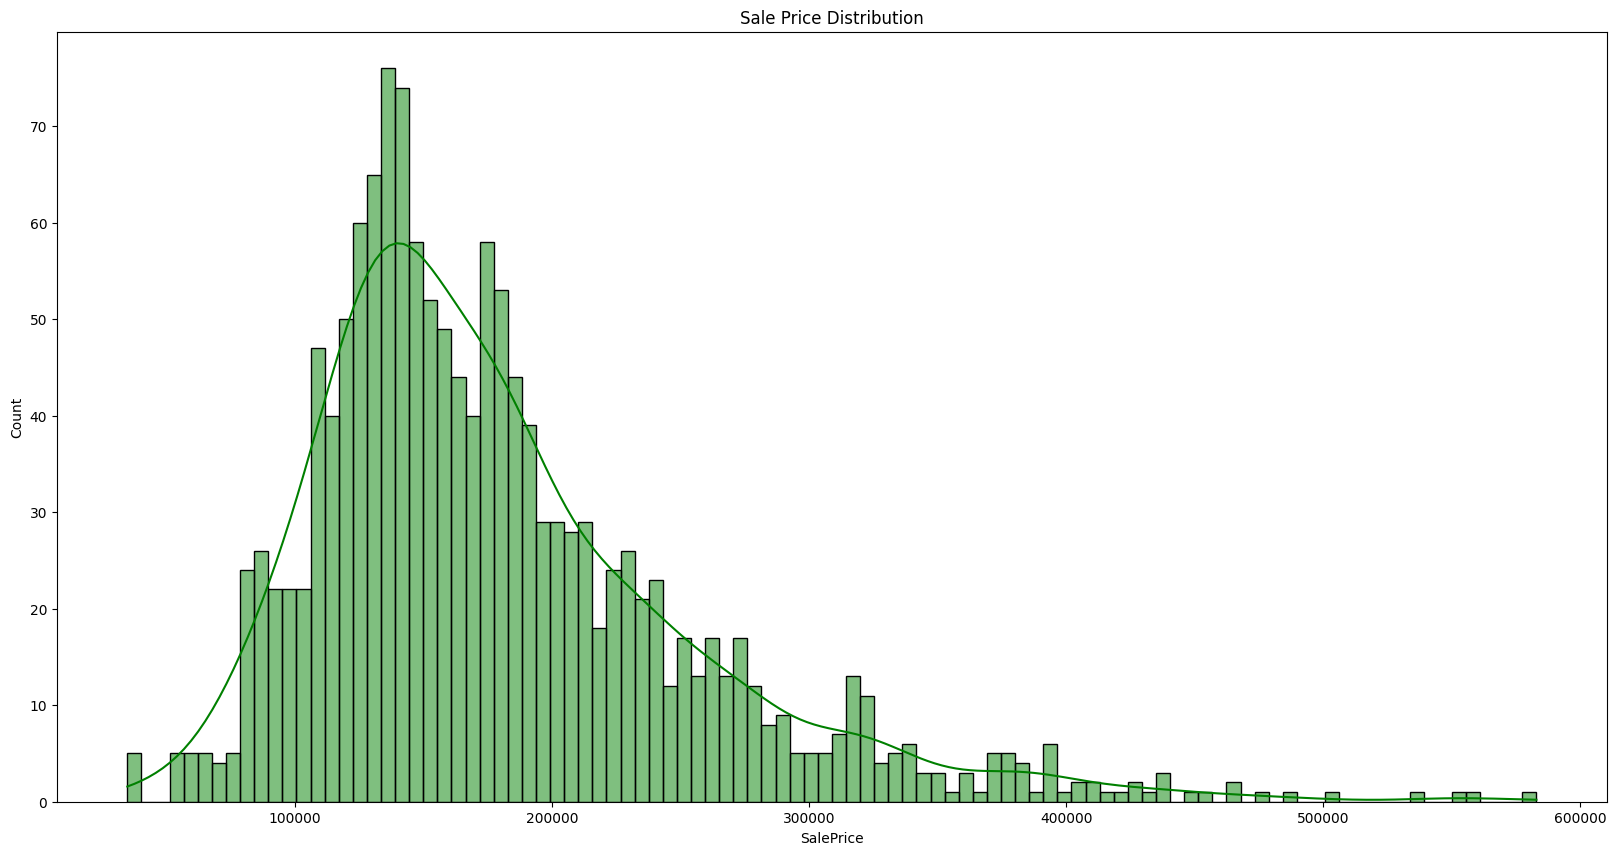

In [6]:
plt.figure(figsize=(20, 10))
sns.histplot(train["SalePrice"], color="g", bins=100, kde=True)
plt.title("Sale Price Distribution")
plt.show()

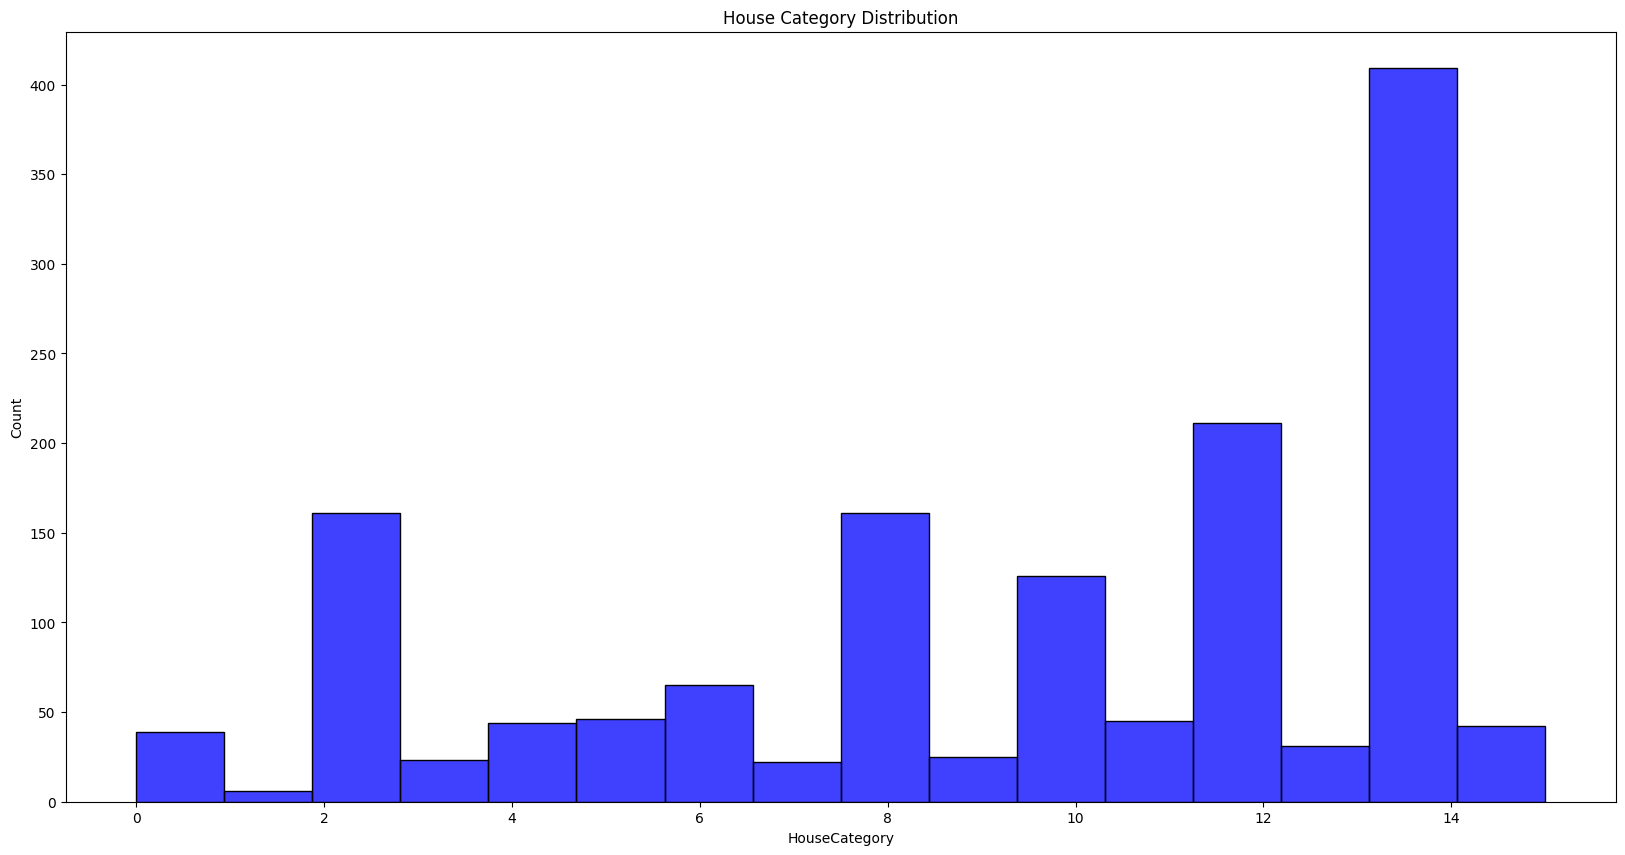

In [67]:
plt.figure(figsize=(20, 10))
sns.histplot(train["HouseCategory"], color="b", bins=16, kde=False)
plt.title("House Category Distribution")
plt.show()

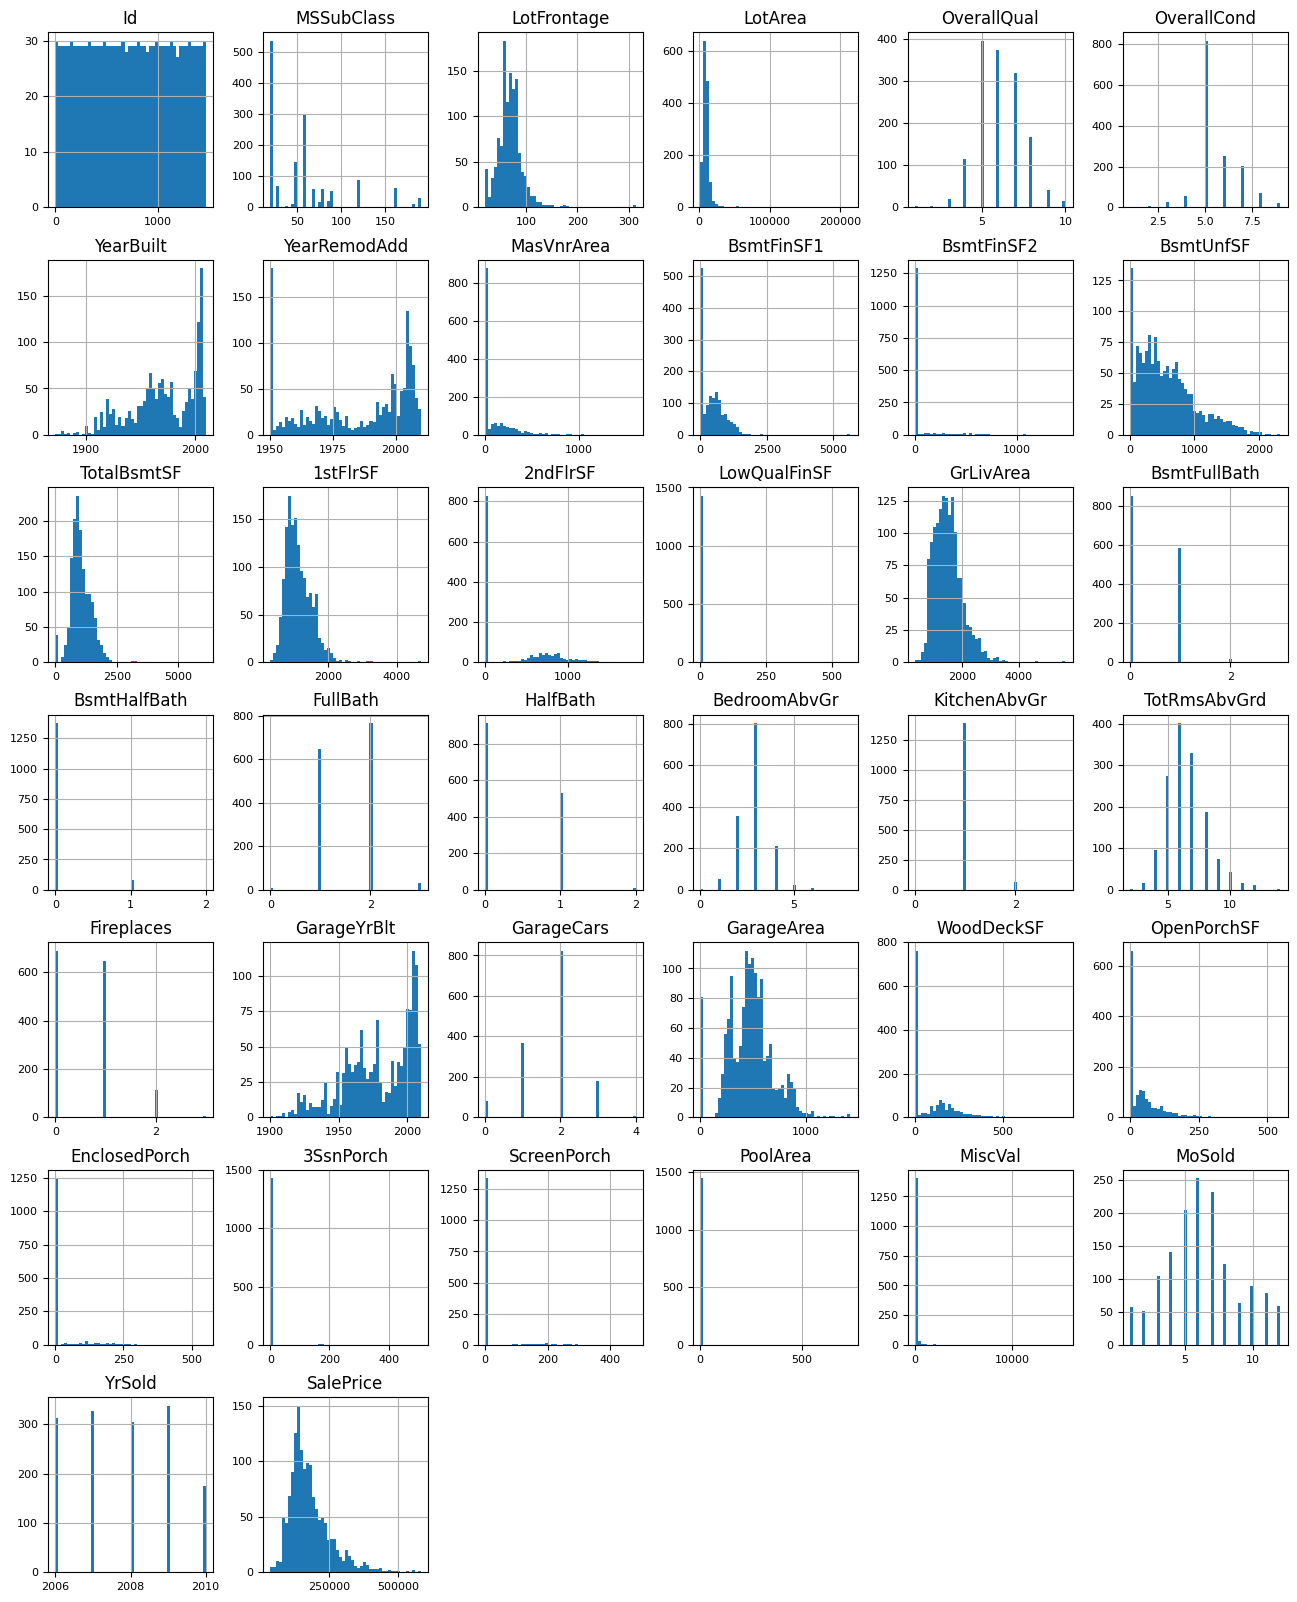

In [7]:
train_numerical = train.select_dtypes(include=["int64", "float64"])
train_numerical.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

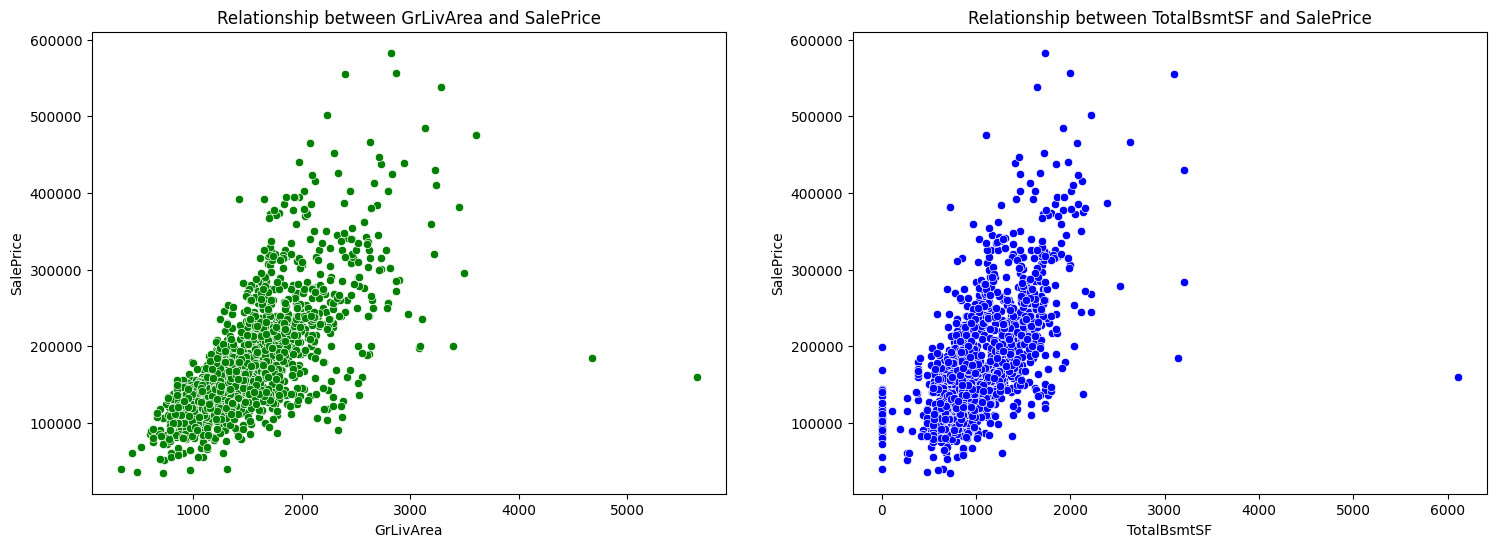

In [8]:
# Relationship between GrLivArea, TotalBsmtSF and SalePrice
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(ax=ax[0], x=train["GrLivArea"], y=train["SalePrice"], color="g")
ax[0].set_title("Relationship between GrLivArea and SalePrice")

sns.scatterplot(ax=ax[1], x=train["TotalBsmtSF"], y=train["SalePrice"], color="b")
ax[1].set_title("Relationship between TotalBsmtSF and SalePrice")

plt.show()


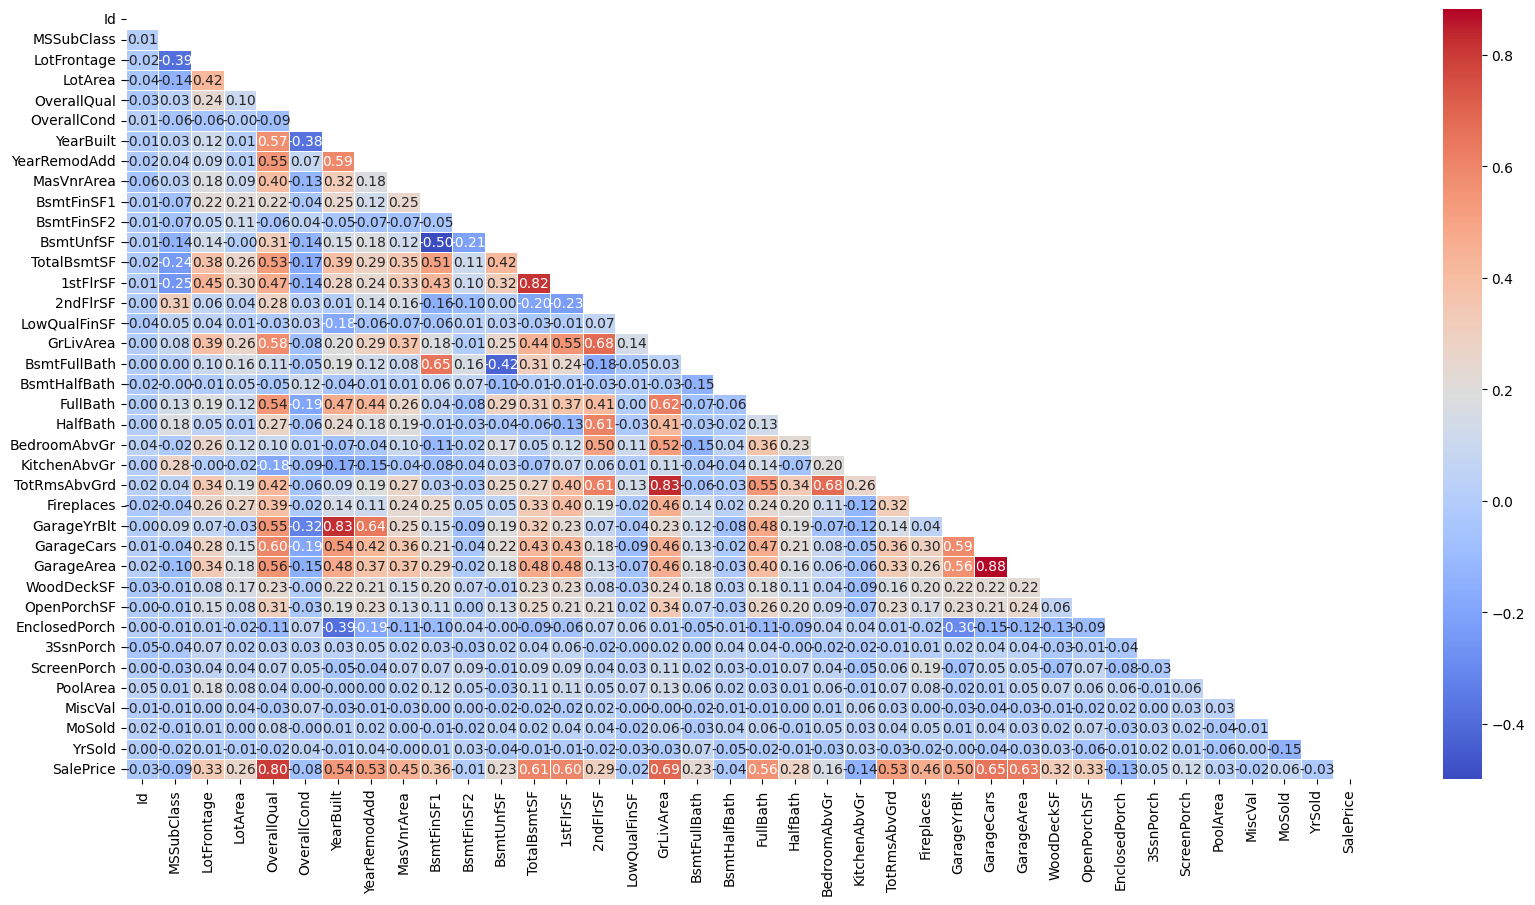

In [9]:
plt.figure(figsize=(20, 10))

sns.heatmap(
    train_numerical.corr(),
    mask=np.triu(np.ones_like(train_numerical.corr(), dtype=bool)),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.show()


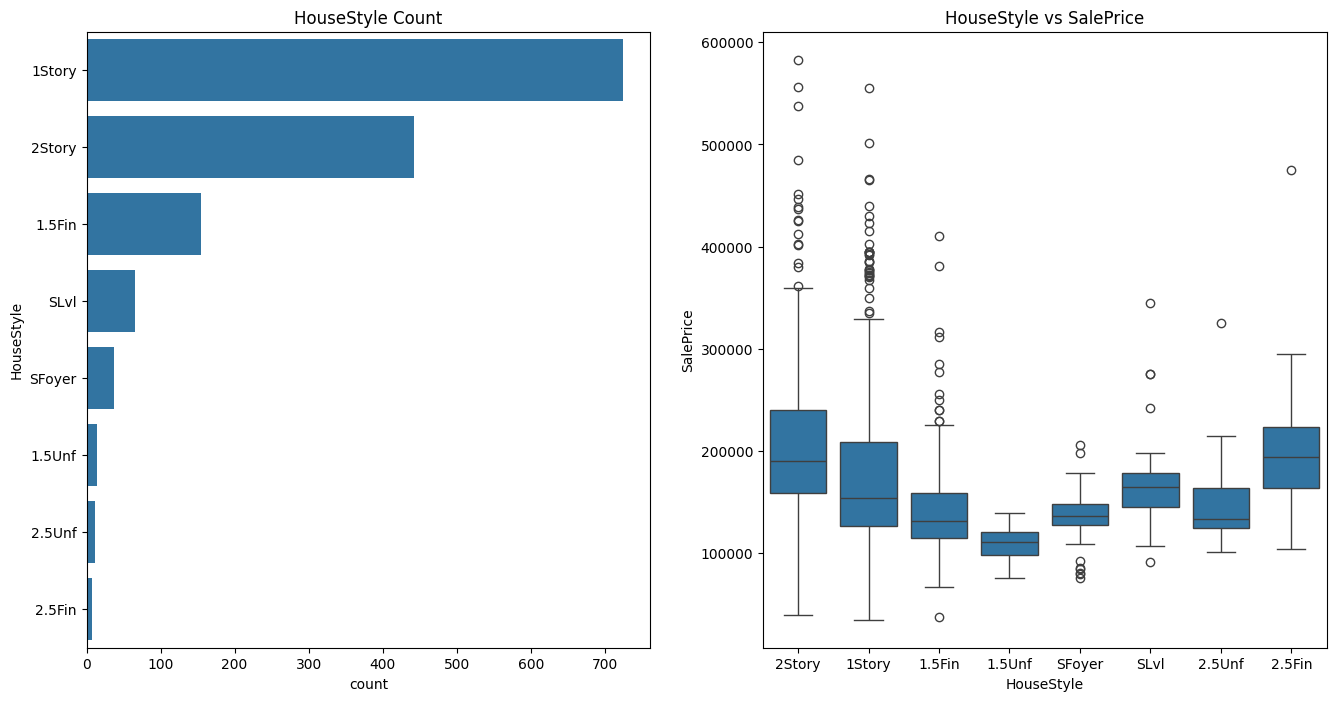

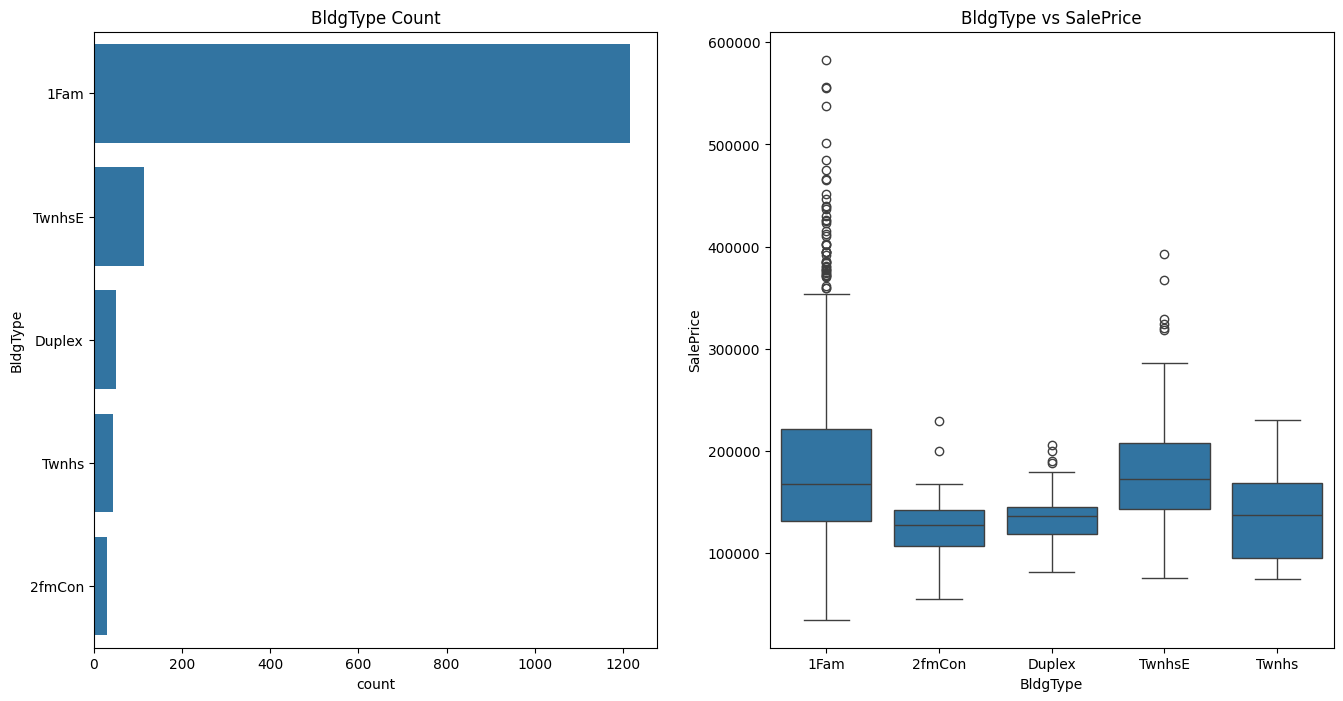

In [10]:
def show_categorical_relationship(df, column):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    sns.countplot(y=column, data=df, order=df[column].value_counts().index, ax=ax[0])
    ax[0].set_title(f"{column} Count")

    sns.boxplot(x=column, y="SalePrice", data=df, ax=ax[1])
    ax[1].set_title(f"{column} vs SalePrice")

    plt.show()

show_categorical_relationship(train, "HouseStyle")
show_categorical_relationship(train, "BldgType")

## Preprocess data

In [11]:
(
    X_train,
    X_val,
    y_train_price,
    y_val_price,
    y_train_category,
    y_val_category,
) = split_data(train)

X_test = test.copy()


In [12]:
X_train = run_pipeline(X_train, fit=True)
X_val = run_pipeline(X_val)
X_test = run_pipeline(X_test)

y_train_price = y_train_price.values.reshape(-1, 1)
y_val_price = y_val_price.values.reshape(-1, 1)
y_train_category = np.array(y_train_category).reshape(-1, 1)
y_val_category = np.array(y_val_category).reshape(-1, 1)

In [13]:
num_cols, cat_cols = get_column_by_type(X_train)
len(num_cols), len(cat_cols)

(31, 48)

In [14]:
X_train, X_val, X_test, label_encoders = label_encode(X_train, X_val, X_test, cat_cols)

In [15]:
(
    X_train.shape,
    X_val.shape,
    y_train_price.shape,
    y_val_price.shape,
    y_train_category.shape,
    y_val_category.shape,
    X_test.shape,
)

((1019, 79), (437, 79), (1019, 1), (437, 1), (1019, 1), (437, 1), (1459, 79))

In [16]:
# Build the dataloaders

train_loader = DataLoader(
    HousingDataset(X_train, y_train_price, y_train_category, cat_cols, num_cols),
    batch_size=32,
    shuffle=True,
    generator=seed,
)

val_loader = DataLoader(
    HousingDataset(X_val, y_val_price, y_val_category, cat_cols, num_cols),
    batch_size=32,
    shuffle=False,
    generator=seed,
)

test_loader = DataLoader(
    HousingDataset(
        X_test,
        np.zeros((X_test.shape[0], 1)),
        np.zeros((X_test.shape[0], 1)),
        cat_cols,
        num_cols,
    ),
    batch_size=32,
    shuffle=False,
    generator=seed,
)

## Hyperparameter tuning

In [21]:
objective = Objective(
        X_train,
        X_val,
        y_train_price,
        y_val_price,
        y_train_category,
        y_val_category,
        cat_cols,
        num_cols,
        label_encoders,
        house_category_encoder,
        max_epochs=100,
)

In [22]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(),
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="housing-optuna",
    load_if_exists=True,
    storage="sqlite:///lightning_logs/housing-final-optuna/housing.db",
)

study.optimize(
    objective,
    n_trials=15,
    timeout=3600,
)


[I 2024-04-22 17:03:09,666] A new study created in RDB with name: housing-optuna
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 192 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.770     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38195654656.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 153808896.000 >= min_delta = 0.0001. New best score: 38041845760.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1406214144.000 >= min_delta = 0.0001. New best score: 36635631616.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3914975232.000 >= min_delta = 0.0001. New best score: 32720656384.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7406942208.000 >= min_delta = 0.0001. New best score: 25313714176.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9998331904.000 >= min_delta = 0.0001. New best score: 15315382272.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6683729920.000 >= min_delta = 0.0001. New best score: 8631652352.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2502812160.000 >= min_delta = 0.0001. New best score: 6128840192.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 200176128.000 >= min_delta = 0.0001. New best score: 5928664064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 15409152.000 >= min_delta = 0.0001. New best score: 5913254912.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9968640.000 >= min_delta = 0.0001. New best score: 5903286272.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4170240.000 >= min_delta = 0.0001. New best score: 5899116032.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3165184.000 >= min_delta = 0.0001. New best score: 5895950848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4411392.000 >= min_delta = 0.0001. New best score: 5891539456.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4972544.000 >= min_delta = 0.0001. New best score: 5886566912.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 766976.000 >= min_delta = 0.0001. New best score: 5885799936.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5885799936.000. Signaling Trainer to stop.
[I 2024-04-22 17:07:13,327] Trial 0 finished with value: 26.94657325744629 and parameters: {'num_layers': 3, 'embedding_dim': 16, 'hidden_dim': 64, 'lr': 0.008123245085588688}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 3.8 M 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.107    Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38692585472.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3280896.000 >= min_delta = 0.0001. New best score: 38689304576.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2908160.000 >= min_delta = 0.0001. New best score: 38686396416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2170880.000 >= min_delta = 0.0001. New best score: 38684225536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2793472.000 >= min_delta = 0.0001. New best score: 38681432064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2871296.000 >= min_delta = 0.0001. New best score: 38678560768.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3366912.000 >= min_delta = 0.0001. New best score: 38675193856.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4182016.000 >= min_delta = 0.0001. New best score: 38671011840.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4849664.000 >= min_delta = 0.0001. New best score: 38666162176.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3014656.000 >= min_delta = 0.0001. New best score: 38663147520.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7143424.000 >= min_delta = 0.0001. New best score: 38656004096.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4259840.000 >= min_delta = 0.0001. New best score: 38651744256.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5009408.000 >= min_delta = 0.0001. New best score: 38646734848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6017024.000 >= min_delta = 0.0001. New best score: 38640717824.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6008832.000 >= min_delta = 0.0001. New best score: 38634708992.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7016448.000 >= min_delta = 0.0001. New best score: 38627692544.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7122944.000 >= min_delta = 0.0001. New best score: 38620569600.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5955584.000 >= min_delta = 0.0001. New best score: 38614614016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7999488.000 >= min_delta = 0.0001. New best score: 38606614528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9699328.000 >= min_delta = 0.0001. New best score: 38596915200.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9326592.000 >= min_delta = 0.0001. New best score: 38587588608.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6832128.000 >= min_delta = 0.0001. New best score: 38580756480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 8376320.000 >= min_delta = 0.0001. New best score: 38572380160.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 12623872.000 >= min_delta = 0.0001. New best score: 38559756288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 8417280.000 >= min_delta = 0.0001. New best score: 38551339008.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 15020032.000 >= min_delta = 0.0001. New best score: 38536318976.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6262784.000 >= min_delta = 0.0001. New best score: 38530056192.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 13996032.000 >= min_delta = 0.0001. New best score: 38516060160.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9797632.000 >= min_delta = 0.0001. New best score: 38506262528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 15155200.000 >= min_delta = 0.0001. New best score: 38491107328.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 872448.000 >= min_delta = 0.0001. New best score: 38490234880.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 13639680.000 >= min_delta = 0.0001. New best score: 38476595200.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 15937536.000 >= min_delta = 0.0001. New best score: 38460657664.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 14266368.000 >= min_delta = 0.0001. New best score: 38446391296.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 14000128.000 >= min_delta = 0.0001. New best score: 38432391168.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 10563584.000 >= min_delta = 0.0001. New best score: 38421827584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 16039936.000 >= min_delta = 0.0001. New best score: 38405787648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9433088.000 >= min_delta = 0.0001. New best score: 38396354560.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 19099648.000 >= min_delta = 0.0001. New best score: 38377254912.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 16580608.000 >= min_delta = 0.0001. New best score: 38360674304.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 14749696.000 >= min_delta = 0.0001. New best score: 38345924608.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 16056320.000 >= min_delta = 0.0001. New best score: 38329868288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 20254720.000 >= min_delta = 0.0001. New best score: 38309613568.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 21172224.000 >= min_delta = 0.0001. New best score: 38288441344.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 18571264.000 >= min_delta = 0.0001. New best score: 38269870080.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 14233600.000 >= min_delta = 0.0001. New best score: 38255636480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 17809408.000 >= min_delta = 0.0001. New best score: 38237827072.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 23293952.000 >= min_delta = 0.0001. New best score: 38214533120.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 25112576.000 >= min_delta = 0.0001. New best score: 38189420544.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 18817024.000 >= min_delta = 0.0001. New best score: 38170603520.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 25559040.000 >= min_delta = 0.0001. New best score: 38145044480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 26951680.000 >= min_delta = 0.0001. New best score: 38118092800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 19890176.000 >= min_delta = 0.0001. New best score: 38098202624.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 25174016.000 >= min_delta = 0.0001. New best score: 38073028608.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 25882624.000 >= min_delta = 0.0001. New best score: 38047145984.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 33001472.000 >= min_delta = 0.0001. New best score: 38014144512.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 31985664.000 >= min_delta = 0.0001. New best score: 37982158848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 13127680.000 >= min_delta = 0.0001. New best score: 37969031168.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 45101056.000 >= min_delta = 0.0001. New best score: 37923930112.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 38313984.000 >= min_delta = 0.0001. New best score: 37885616128.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 16457728.000 >= min_delta = 0.0001. New best score: 37869158400.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 30330880.000 >= min_delta = 0.0001. New best score: 37838827520.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 51789824.000 >= min_delta = 0.0001. New best score: 37787037696.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 29888512.000 >= min_delta = 0.0001. New best score: 37757149184.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 49995776.000 >= min_delta = 0.0001. New best score: 37707153408.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9007104.000 >= min_delta = 0.0001. New best score: 37698146304.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 59670528.000 >= min_delta = 0.0001. New best score: 37638475776.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 36048896.000 >= min_delta = 0.0001. New best score: 37602426880.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 35958784.000 >= min_delta = 0.0001. New best score: 37566468096.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 110952448.000 >= min_delta = 0.0001. New best score: 37455515648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 40984576.000 >= min_delta = 0.0001. New best score: 37414531072.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 40042496.000 >= min_delta = 0.0001. New best score: 37374488576.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 32972800.000 >= min_delta = 0.0001. New best score: 37341515776.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 38797312.000 >= min_delta = 0.0001. New best score: 37302718464.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 62578688.000 >= min_delta = 0.0001. New best score: 37240139776.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 49618944.000 >= min_delta = 0.0001. New best score: 37190520832.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 43143168.000 >= min_delta = 0.0001. New best score: 37147377664.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 53956608.000 >= min_delta = 0.0001. New best score: 37093421056.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 61063168.000 >= min_delta = 0.0001. New best score: 37032357888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 49528832.000 >= min_delta = 0.0001. New best score: 36982829056.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 51793920.000 >= min_delta = 0.0001. New best score: 36931035136.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 68689920.000 >= min_delta = 0.0001. New best score: 36862345216.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 41521152.000 >= min_delta = 0.0001. New best score: 36820824064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 86560768.000 >= min_delta = 0.0001. New best score: 36734263296.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 44302336.000 >= min_delta = 0.0001. New best score: 36689960960.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 65097728.000 >= min_delta = 0.0001. New best score: 36624863232.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 57282560.000 >= min_delta = 0.0001. New best score: 36567580672.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 51679232.000 >= min_delta = 0.0001. New best score: 36515901440.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 73523200.000 >= min_delta = 0.0001. New best score: 36442378240.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 53886976.000 >= min_delta = 0.0001. New best score: 36388491264.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 99241984.000 >= min_delta = 0.0001. New best score: 36289249280.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 72798208.000 >= min_delta = 0.0001. New best score: 36216451072.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 58073088.000 >= min_delta = 0.0001. New best score: 36158377984.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 72876032.000 >= min_delta = 0.0001. New best score: 36085501952.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 86278144.000 >= min_delta = 0.0001. New best score: 35999223808.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 64081920.000 >= min_delta = 0.0001. New best score: 35935141888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 121008128.000 >= min_delta = 0.0001. New best score: 35814133760.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3923968.000 >= min_delta = 0.0001. New best score: 35810209792.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 73519104.000 >= min_delta = 0.0001. New best score: 35736690688.000
`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-04-22 17:18:35,049] Trial 1 finished with value: 77.03866577148438 and parameters: {'num_layers': 6, 'embedding_dim': 256, 'hidden_dim': 128, 'lr': 0.00012562773503807024}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 7.1 M 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 36939522048.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2074357760.000 >= min_delta = 0.0001. New best score: 34865164288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7919165440.000 >= min_delta = 0.0001. New best score: 26945998848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 11994637312.000 >= min_delta = 0.0001. New best score: 14951361536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7265823744.000 >= min_delta = 0.0001. New best score: 7685537792.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1674840064.000 >= min_delta = 0.0001. New best score: 6010697728.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2567680.000 >= min_delta = 0.0001. New best score: 6008130048.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 50143232.000 >= min_delta = 0.0001. New best score: 5957986816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 57562624.000 >= min_delta = 0.0001. New best score: 5900424192.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 10741760.000 >= min_delta = 0.0001. New best score: 5889682432.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 10956288.000 >= min_delta = 0.0001. New best score: 5878726144.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5878726144.000. Signaling Trainer to stop.
[I 2024-04-22 17:24:00,056] Trial 2 finished with value: 29.957794189453125 and parameters: {'num_layers': 4, 'embedding_dim': 16, 'hidden_dim': 512, 'lr': 0.002661901888489057}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 296 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.186     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38691688448.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3403776.000 >= min_delta = 0.0001. New best score: 38688284672.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3796992.000 >= min_delta = 0.0001. New best score: 38684487680.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4358144.000 >= min_delta = 0.0001. New best score: 38680129536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3796992.000 >= min_delta = 0.0001. New best score: 38676332544.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6885376.000 >= min_delta = 0.0001. New best score: 38669447168.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5795840.000 >= min_delta = 0.0001. New best score: 38663651328.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7360512.000 >= min_delta = 0.0001. New best score: 38656290816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 8466432.000 >= min_delta = 0.0001. New best score: 38647824384.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 10178560.000 >= min_delta = 0.0001. New best score: 38637645824.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6823936.000 >= min_delta = 0.0001. New best score: 38630821888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 13234176.000 >= min_delta = 0.0001. New best score: 38617587712.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 10493952.000 >= min_delta = 0.0001. New best score: 38607093760.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 12447744.000 >= min_delta = 0.0001. New best score: 38594646016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 11304960.000 >= min_delta = 0.0001. New best score: 38583341056.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 23392256.000 >= min_delta = 0.0001. New best score: 38559948800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 12107776.000 >= min_delta = 0.0001. New best score: 38547841024.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 15831040.000 >= min_delta = 0.0001. New best score: 38532009984.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 13930496.000 >= min_delta = 0.0001. New best score: 38518079488.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 18448384.000 >= min_delta = 0.0001. New best score: 38499631104.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 27095040.000 >= min_delta = 0.0001. New best score: 38472536064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 12414976.000 >= min_delta = 0.0001. New best score: 38460121088.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 28086272.000 >= min_delta = 0.0001. New best score: 38432034816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 23007232.000 >= min_delta = 0.0001. New best score: 38409027584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 30777344.000 >= min_delta = 0.0001. New best score: 38378250240.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 35565568.000 >= min_delta = 0.0001. New best score: 38342684672.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 48070656.000 >= min_delta = 0.0001. New best score: 38294614016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6488064.000 >= min_delta = 0.0001. New best score: 38288125952.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 44634112.000 >= min_delta = 0.0001. New best score: 38243491840.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 21635072.000 >= min_delta = 0.0001. New best score: 38221856768.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 43016192.000 >= min_delta = 0.0001. New best score: 38178840576.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 23044096.000 >= min_delta = 0.0001. New best score: 38155796480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 49643520.000 >= min_delta = 0.0001. New best score: 38106152960.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 20676608.000 >= min_delta = 0.0001. New best score: 38085476352.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 48132096.000 >= min_delta = 0.0001. New best score: 38037344256.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 56893440.000 >= min_delta = 0.0001. New best score: 37980450816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 31858688.000 >= min_delta = 0.0001. New best score: 37948592128.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 58732544.000 >= min_delta = 0.0001. New best score: 37889859584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 56602624.000 >= min_delta = 0.0001. New best score: 37833256960.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 63500288.000 >= min_delta = 0.0001. New best score: 37769756672.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 57438208.000 >= min_delta = 0.0001. New best score: 37712318464.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 61636608.000 >= min_delta = 0.0001. New best score: 37650681856.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 85688320.000 >= min_delta = 0.0001. New best score: 37564993536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 68435968.000 >= min_delta = 0.0001. New best score: 37496557568.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 69849088.000 >= min_delta = 0.0001. New best score: 37426708480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 75911168.000 >= min_delta = 0.0001. New best score: 37350797312.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 92647424.000 >= min_delta = 0.0001. New best score: 37258149888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 78954496.000 >= min_delta = 0.0001. New best score: 37179195392.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 116400128.000 >= min_delta = 0.0001. New best score: 37062795264.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 144003072.000 >= min_delta = 0.0001. New best score: 36918792192.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 57098240.000 >= min_delta = 0.0001. New best score: 36861693952.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 59170816.000 >= min_delta = 0.0001. New best score: 36802523136.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 91275264.000 >= min_delta = 0.0001. New best score: 36711247872.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 164212736.000 >= min_delta = 0.0001. New best score: 36547035136.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 179609600.000 >= min_delta = 0.0001. New best score: 36367425536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 77533184.000 >= min_delta = 0.0001. New best score: 36289892352.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 62160896.000 >= min_delta = 0.0001. New best score: 36227731456.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 124035072.000 >= min_delta = 0.0001. New best score: 36103696384.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 237121536.000 >= min_delta = 0.0001. New best score: 35866574848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 76013568.000 >= min_delta = 0.0001. New best score: 35790561280.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 218537984.000 >= min_delta = 0.0001. New best score: 35572023296.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 337977344.000 >= min_delta = 0.0001. New best score: 35234045952.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 126402560.000 >= min_delta = 0.0001. New best score: 35107643392.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 159956992.000 >= min_delta = 0.0001. New best score: 34947686400.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 141713408.000 >= min_delta = 0.0001. New best score: 34805972992.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 134426624.000 >= min_delta = 0.0001. New best score: 34671546368.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 272502784.000 >= min_delta = 0.0001. New best score: 34399043584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 170379264.000 >= min_delta = 0.0001. New best score: 34228664320.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 169668608.000 >= min_delta = 0.0001. New best score: 34058995712.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 205084672.000 >= min_delta = 0.0001. New best score: 33853911040.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 189325312.000 >= min_delta = 0.0001. New best score: 33664585728.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 91054080.000 >= min_delta = 0.0001. New best score: 33573531648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 284344320.000 >= min_delta = 0.0001. New best score: 33289187328.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 307570688.000 >= min_delta = 0.0001. New best score: 32981616640.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 234674176.000 >= min_delta = 0.0001. New best score: 32746942464.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 168486912.000 >= min_delta = 0.0001. New best score: 32578455552.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 241881088.000 >= min_delta = 0.0001. New best score: 32336574464.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 279681024.000 >= min_delta = 0.0001. New best score: 32056893440.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 361979904.000 >= min_delta = 0.0001. New best score: 31694913536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 243591168.000 >= min_delta = 0.0001. New best score: 31451322368.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 65103872.000 >= min_delta = 0.0001. New best score: 31386218496.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 514809856.000 >= min_delta = 0.0001. New best score: 30871408640.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 242673664.000 >= min_delta = 0.0001. New best score: 30628734976.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 168321024.000 >= min_delta = 0.0001. New best score: 30460413952.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 247343104.000 >= min_delta = 0.0001. New best score: 30213070848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 257552384.000 >= min_delta = 0.0001. New best score: 29955518464.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 255625216.000 >= min_delta = 0.0001. New best score: 29699893248.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 267421696.000 >= min_delta = 0.0001. New best score: 29432471552.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 296888320.000 >= min_delta = 0.0001. New best score: 29135583232.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 321552384.000 >= min_delta = 0.0001. New best score: 28814030848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 253184000.000 >= min_delta = 0.0001. New best score: 28560846848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 260534272.000 >= min_delta = 0.0001. New best score: 28300312576.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 260317184.000 >= min_delta = 0.0001. New best score: 28039995392.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 285589504.000 >= min_delta = 0.0001. New best score: 27754405888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 244813824.000 >= min_delta = 0.0001. New best score: 27509592064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 347756544.000 >= min_delta = 0.0001. New best score: 27161835520.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 307734528.000 >= min_delta = 0.0001. New best score: 26854100992.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 237639680.000 >= min_delta = 0.0001. New best score: 26616461312.000
`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-04-22 17:32:15,096] Trial 3 finished with value: 51.07040023803711 and parameters: {'num_layers': 3, 'embedding_dim': 32, 'hidden_dim': 64, 'lr': 0.00036324869566766035}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 313 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38693339136.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1163264.000 >= min_delta = 0.0001. New best score: 38692175872.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 708608.000 >= min_delta = 0.0001. New best score: 38691467264.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 733184.000 >= min_delta = 0.0001. New best score: 38690734080.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 626688.000 >= min_delta = 0.0001. New best score: 38690107392.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 745472.000 >= min_delta = 0.0001. New best score: 38689361920.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 757760.000 >= min_delta = 0.0001. New best score: 38688604160.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 839680.000 >= min_delta = 0.0001. New best score: 38687764480.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 675840.000 >= min_delta = 0.0001. New best score: 38687088640.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1048576.000 >= min_delta = 0.0001. New best score: 38686040064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1163264.000 >= min_delta = 0.0001. New best score: 38684876800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 929792.000 >= min_delta = 0.0001. New best score: 38683947008.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 925696.000 >= min_delta = 0.0001. New best score: 38683021312.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1286144.000 >= min_delta = 0.0001. New best score: 38681735168.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 970752.000 >= min_delta = 0.0001. New best score: 38680764416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1384448.000 >= min_delta = 0.0001. New best score: 38679379968.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 995328.000 >= min_delta = 0.0001. New best score: 38678384640.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1810432.000 >= min_delta = 0.0001. New best score: 38676574208.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 905216.000 >= min_delta = 0.0001. New best score: 38675668992.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1478656.000 >= min_delta = 0.0001. New best score: 38674190336.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1822720.000 >= min_delta = 0.0001. New best score: 38672367616.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1482752.000 >= min_delta = 0.0001. New best score: 38670884864.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1146880.000 >= min_delta = 0.0001. New best score: 38669737984.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2195456.000 >= min_delta = 0.0001. New best score: 38667542528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1265664.000 >= min_delta = 0.0001. New best score: 38666276864.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1462272.000 >= min_delta = 0.0001. New best score: 38664814592.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1937408.000 >= min_delta = 0.0001. New best score: 38662877184.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1757184.000 >= min_delta = 0.0001. New best score: 38661120000.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1961984.000 >= min_delta = 0.0001. New best score: 38659158016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1527808.000 >= min_delta = 0.0001. New best score: 38657630208.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2568192.000 >= min_delta = 0.0001. New best score: 38655062016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2277376.000 >= min_delta = 0.0001. New best score: 38652784640.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1957888.000 >= min_delta = 0.0001. New best score: 38650826752.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1171456.000 >= min_delta = 0.0001. New best score: 38649655296.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3096576.000 >= min_delta = 0.0001. New best score: 38646558720.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1777664.000 >= min_delta = 0.0001. New best score: 38644781056.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3215360.000 >= min_delta = 0.0001. New best score: 38641565696.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1675264.000 >= min_delta = 0.0001. New best score: 38639890432.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2039808.000 >= min_delta = 0.0001. New best score: 38637850624.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2125824.000 >= min_delta = 0.0001. New best score: 38635724800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3112960.000 >= min_delta = 0.0001. New best score: 38632611840.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2326528.000 >= min_delta = 0.0001. New best score: 38630285312.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2752512.000 >= min_delta = 0.0001. New best score: 38627532800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2527232.000 >= min_delta = 0.0001. New best score: 38625005568.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3158016.000 >= min_delta = 0.0001. New best score: 38621847552.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1699840.000 >= min_delta = 0.0001. New best score: 38620147712.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3108864.000 >= min_delta = 0.0001. New best score: 38617038848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1576960.000 >= min_delta = 0.0001. New best score: 38615461888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5484544.000 >= min_delta = 0.0001. New best score: 38609977344.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 507904.000 >= min_delta = 0.0001. New best score: 38609469440.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3227648.000 >= min_delta = 0.0001. New best score: 38606241792.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3239936.000 >= min_delta = 0.0001. New best score: 38603001856.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3018752.000 >= min_delta = 0.0001. New best score: 38599983104.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2527232.000 >= min_delta = 0.0001. New best score: 38597455872.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4341760.000 >= min_delta = 0.0001. New best score: 38593114112.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2818048.000 >= min_delta = 0.0001. New best score: 38590296064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5885952.000 >= min_delta = 0.0001. New best score: 38584410112.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 512000.000 >= min_delta = 0.0001. New best score: 38583898112.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2461696.000 >= min_delta = 0.0001. New best score: 38581436416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6590464.000 >= min_delta = 0.0001. New best score: 38574845952.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4567040.000 >= min_delta = 0.0001. New best score: 38570278912.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4939776.000 >= min_delta = 0.0001. New best score: 38565339136.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3530752.000 >= min_delta = 0.0001. New best score: 38561808384.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3170304.000 >= min_delta = 0.0001. New best score: 38558638080.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1847296.000 >= min_delta = 0.0001. New best score: 38556790784.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4538368.000 >= min_delta = 0.0001. New best score: 38552252416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5406720.000 >= min_delta = 0.0001. New best score: 38546845696.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2494464.000 >= min_delta = 0.0001. New best score: 38544351232.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4243456.000 >= min_delta = 0.0001. New best score: 38540107776.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5951488.000 >= min_delta = 0.0001. New best score: 38534156288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2748416.000 >= min_delta = 0.0001. New best score: 38531407872.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3219456.000 >= min_delta = 0.0001. New best score: 38528188416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4816896.000 >= min_delta = 0.0001. New best score: 38523371520.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6549504.000 >= min_delta = 0.0001. New best score: 38516822016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3272704.000 >= min_delta = 0.0001. New best score: 38513549312.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6250496.000 >= min_delta = 0.0001. New best score: 38507298816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2654208.000 >= min_delta = 0.0001. New best score: 38504644608.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3608576.000 >= min_delta = 0.0001. New best score: 38501036032.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4268032.000 >= min_delta = 0.0001. New best score: 38496768000.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9949184.000 >= min_delta = 0.0001. New best score: 38486818816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1122304.000 >= min_delta = 0.0001. New best score: 38485696512.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4145152.000 >= min_delta = 0.0001. New best score: 38481551360.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7598080.000 >= min_delta = 0.0001. New best score: 38473953280.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4784128.000 >= min_delta = 0.0001. New best score: 38469169152.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4259840.000 >= min_delta = 0.0001. New best score: 38464909312.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5828608.000 >= min_delta = 0.0001. New best score: 38459080704.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 10117120.000 >= min_delta = 0.0001. New best score: 38448963584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6729728.000 >= min_delta = 0.0001. New best score: 38442233856.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6209536.000 >= min_delta = 0.0001. New best score: 38436024320.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 8814592.000 >= min_delta = 0.0001. New best score: 38427209728.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 12193792.000 >= min_delta = 0.0001. New best score: 38415015936.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1548288.000 >= min_delta = 0.0001. New best score: 38413467648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5464064.000 >= min_delta = 0.0001. New best score: 38408003584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5820416.000 >= min_delta = 0.0001. New best score: 38402183168.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 28037120.000 >= min_delta = 0.0001. New best score: 38374146048.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-04-22 17:40:30,474] Trial 4 finished with value: 86.03472900390625 and parameters: {'num_layers': 4, 'embedding_dim': 32, 'hidden_dim': 64, 'lr': 9.46217535646148e-05}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 2.1 M 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.540     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-22 17:40:59,069] Trial 5 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 476 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
476 K     Trainable params
0         Non-trainable params
476 K     Total params
1.908     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-22 17:41:12,745] Trial 6 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 11.6 M
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.531    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38664712192.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 97153024.000 >= min_delta = 0.0001. New best score: 38567559168.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 100880384.000 >= min_delta = 0.0001. New best score: 38466678784.000


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-22 17:43:35,196] Trial 7 pruned. Trial was pruned at epoch 3.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 3.6 M 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.576    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38614228992.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 75403264.000 >= min_delta = 0.0001. New best score: 38538825728.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 244379648.000 >= min_delta = 0.0001. New best score: 38294446080.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 292548608.000 >= min_delta = 0.0001. New best score: 38001897472.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 410275840.000 >= min_delta = 0.0001. New best score: 37591621632.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 821030912.000 >= min_delta = 0.0001. New best score: 36770590720.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 595132416.000 >= min_delta = 0.0001. New best score: 36175458304.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1438363648.000 >= min_delta = 0.0001. New best score: 34737094656.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2351298560.000 >= min_delta = 0.0001. New best score: 32385796096.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 998074368.000 >= min_delta = 0.0001. New best score: 31387721728.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3669663744.000 >= min_delta = 0.0001. New best score: 27718057984.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3680225280.000 >= min_delta = 0.0001. New best score: 24037832704.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3186364416.000 >= min_delta = 0.0001. New best score: 20851468288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3585894400.000 >= min_delta = 0.0001. New best score: 17265573888.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3310236672.000 >= min_delta = 0.0001. New best score: 13955337216.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2844249088.000 >= min_delta = 0.0001. New best score: 11111088128.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1916084224.000 >= min_delta = 0.0001. New best score: 9195003904.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1529451008.000 >= min_delta = 0.0001. New best score: 7665552896.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 696622592.000 >= min_delta = 0.0001. New best score: 6968930304.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 582995456.000 >= min_delta = 0.0001. New best score: 6385934848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 187888640.000 >= min_delta = 0.0001. New best score: 6198046208.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 135434240.000 >= min_delta = 0.0001. New best score: 6062611968.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 44844032.000 >= min_delta = 0.0001. New best score: 6017767936.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 49934848.000 >= min_delta = 0.0001. New best score: 5967833088.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 20794880.000 >= min_delta = 0.0001. New best score: 5947038208.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 36743680.000 >= min_delta = 0.0001. New best score: 5910294528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6391808.000 >= min_delta = 0.0001. New best score: 5903902720.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 13528064.000 >= min_delta = 0.0001. New best score: 5890374656.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5890374656.000. Signaling Trainer to stop.
[I 2024-04-22 17:48:05,498] Trial 8 finished with value: 29.31180763244629 and parameters: {'num_layers': 4, 'embedding_dim': 256, 'hidden_dim': 128, 'lr': 0.0018477934173519257}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 11.6 M
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.531    Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-22 17:49:57,948] Trial 9 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 256 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
256 K     Trainable params
0         Non-trainable params
256 K     Total params
1.024     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38641192960.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 112377856.000 >= min_delta = 0.0001. New best score: 38528815104.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 191356928.000 >= min_delta = 0.0001. New best score: 38337458176.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 364924928.000 >= min_delta = 0.0001. New best score: 37972533248.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 771219456.000 >= min_delta = 0.0001. New best score: 37201313792.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1366441984.000 >= min_delta = 0.0001. New best score: 35834871808.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2575931392.000 >= min_delta = 0.0001. New best score: 33258940416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3312332800.000 >= min_delta = 0.0001. New best score: 29946607616.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5255385088.000 >= min_delta = 0.0001. New best score: 24691222528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5691142144.000 >= min_delta = 0.0001. New best score: 19000080384.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5672458240.000 >= min_delta = 0.0001. New best score: 13327622144.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4180654080.000 >= min_delta = 0.0001. New best score: 9146968064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1977139712.000 >= min_delta = 0.0001. New best score: 7169828352.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 892538368.000 >= min_delta = 0.0001. New best score: 6277289984.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 222654976.000 >= min_delta = 0.0001. New best score: 6054635008.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 84721152.000 >= min_delta = 0.0001. New best score: 5969913856.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 61012480.000 >= min_delta = 0.0001. New best score: 5908901376.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 18730496.000 >= min_delta = 0.0001. New best score: 5890170880.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5890170880.000. Signaling Trainer to stop.
[I 2024-04-22 17:52:19,724] Trial 10 finished with value: 27.090635299682617 and parameters: {'num_layers': 6, 'embedding_dim': 64, 'hidden_dim': 32, 'lr': 0.007332884431753989}. Best is trial 0 with value: 26.94657325744629.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 256 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
256 K     Trainable params
0         Non-trainable params
256 K     Total params
1.024     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38610710528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 126554112.000 >= min_delta = 0.0001. New best score: 38484156416.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 324153344.000 >= min_delta = 0.0001. New best score: 38160003072.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 855646208.000 >= min_delta = 0.0001. New best score: 37304356864.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1685041152.000 >= min_delta = 0.0001. New best score: 35619315712.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3653519360.000 >= min_delta = 0.0001. New best score: 31965796352.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5637386240.000 >= min_delta = 0.0001. New best score: 26328410112.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7205986304.000 >= min_delta = 0.0001. New best score: 19122423808.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7012460544.000 >= min_delta = 0.0001. New best score: 12109963264.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4392111616.000 >= min_delta = 0.0001. New best score: 7717851648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1344900608.000 >= min_delta = 0.0001. New best score: 6372951040.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 265844224.000 >= min_delta = 0.0001. New best score: 6107106816.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 174315008.000 >= min_delta = 0.0001. New best score: 5932791808.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1320960.000 >= min_delta = 0.0001. New best score: 5931470848.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 11080704.000 >= min_delta = 0.0001. New best score: 5920390144.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9530880.000 >= min_delta = 0.0001. New best score: 5910859264.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9780736.000 >= min_delta = 0.0001. New best score: 5901078528.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 9651200.000 >= min_delta = 0.0001. New best score: 5891427328.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 739328.000 >= min_delta = 0.0001. New best score: 5890688000.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1660416.000 >= min_delta = 0.0001. New best score: 5889027584.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4049408.000 >= min_delta = 0.0001. New best score: 5884978176.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5884978176.000. Signaling Trainer to stop.
[I 2024-04-22 17:54:58,559] Trial 11 finished with value: 26.881031036376953 and parameters: {'num_layers': 6, 'embedding_dim': 64, 'hidden_dim': 32, 'lr': 0.00911692530818968}. Best is trial 11 with value: 26.881031036376953.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 251 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.007     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38588203008.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 88436736.000 >= min_delta = 0.0001. New best score: 38499766272.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 185012224.000 >= min_delta = 0.0001. New best score: 38314754048.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 611368960.000 >= min_delta = 0.0001. New best score: 37703385088.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 937795584.000 >= min_delta = 0.0001. New best score: 36765589504.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2273243136.000 >= min_delta = 0.0001. New best score: 34492346368.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4083208192.000 >= min_delta = 0.0001. New best score: 30409138176.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4296732672.000 >= min_delta = 0.0001. New best score: 26112405504.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6046330880.000 >= min_delta = 0.0001. New best score: 20066074624.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6744095744.000 >= min_delta = 0.0001. New best score: 13321978880.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4301224960.000 >= min_delta = 0.0001. New best score: 9020753920.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2064901632.000 >= min_delta = 0.0001. New best score: 6955852288.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 555673088.000 >= min_delta = 0.0001. New best score: 6400179200.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 370769920.000 >= min_delta = 0.0001. New best score: 6029409280.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 98947584.000 >= min_delta = 0.0001. New best score: 5930461696.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 12008448.000 >= min_delta = 0.0001. New best score: 5918453248.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6390784.000 >= min_delta = 0.0001. New best score: 5912062464.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 11192832.000 >= min_delta = 0.0001. New best score: 5900869632.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1210368.000 >= min_delta = 0.0001. New best score: 5899659264.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2172928.000 >= min_delta = 0.0001. New best score: 5897486336.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5650432.000 >= min_delta = 0.0001. New best score: 5891835904.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2952192.000 >= min_delta = 0.0001. New best score: 5888883712.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5888883712.000. Signaling Trainer to stop.
[I 2024-04-22 17:58:50,303] Trial 12 finished with value: 26.608016967773438 and parameters: {'num_layers': 5, 'embedding_dim': 64, 'hidden_dim': 32, 'lr': 0.00805389510708543}. Best is trial 12 with value: 26.608016967773438.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 251 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.007     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-22 17:59:00,518] Trial 13 pruned. Trial was pruned at epoch 0.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | HousingNetwork   | 251 K 
1 | loss_fn_price    | MSELoss          | 0     
2 | loss_fn_category | CrossEntropyLoss | 0     
  | other params     | n/a              | 2     
------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.007     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved. New best score: 38581305344.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 50761728.000 >= min_delta = 0.0001. New best score: 38530543616.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 356655104.000 >= min_delta = 0.0001. New best score: 38173888512.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 495640576.000 >= min_delta = 0.0001. New best score: 37678247936.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1386246144.000 >= min_delta = 0.0001. New best score: 36292001792.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 2269536256.000 >= min_delta = 0.0001. New best score: 34022465536.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4402804736.000 >= min_delta = 0.0001. New best score: 29619660800.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4634228736.000 >= min_delta = 0.0001. New best score: 24985432064.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6821736448.000 >= min_delta = 0.0001. New best score: 18163695616.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 6232657920.000 >= min_delta = 0.0001. New best score: 11931037696.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3706278912.000 >= min_delta = 0.0001. New best score: 8224758784.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 1737964032.000 >= min_delta = 0.0001. New best score: 6486794752.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 447214080.000 >= min_delta = 0.0001. New best score: 6039580672.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 98433024.000 >= min_delta = 0.0001. New best score: 5941147648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 24704000.000 >= min_delta = 0.0001. New best score: 5916443648.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 3013632.000 >= min_delta = 0.0001. New best score: 5913430016.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 11502080.000 >= min_delta = 0.0001. New best score: 5901927936.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 4432896.000 >= min_delta = 0.0001. New best score: 5897495040.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 5382144.000 >= min_delta = 0.0001. New best score: 5892112896.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_price improved by 7301120.000 >= min_delta = 0.0001. New best score: 5884811776.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss_price did not improve in the last 10 records. Best score: 5884811776.000. Signaling Trainer to stop.
[I 2024-04-22 18:01:58,473] Trial 14 finished with value: 27.00008773803711 and parameters: {'num_layers': 5, 'embedding_dim': 64, 'hidden_dim': 32, 'lr': 0.008242823051943272}. Best is trial 12 with value: 26.608016967773438.


In [34]:
trials = study.trials_dataframe().sort_values(by="value", ascending=True)

best_trials = trials.head(3)

best_trials

,number,value,datetime_start,datetime_complete,duration,params_embedding_dim,params_hidden_dim,params_lr,params_num_layers,state
12,12,26.608017,2024-04-22 17:54:58.568654,2024-04-22 17:58:50.250676,0 days 00:03:51.682022,64,32,0.008054,5,COMPLETE
11,11,26.881031,2024-04-22 17:52:19.734671,2024-04-22 17:54:58.488380,0 days 00:02:38.753709,64,32,0.009117,6,COMPLETE
0,0,26.946573,2024-04-22 17:03:09.678115,2024-04-22 17:07:13.065154,0 days 00:04:03.387039,16,64,0.008123,3,COMPLETE


In [44]:
trial_metrics = {}

for index, trial in best_trials.iterrows():
    ckpt_path = (
        f'./lightning_logs/housing-final-optuna/version_{trial["number"]}/checkpoints/'
    )

    network_trial = HousingModel.load_from_checkpoint(
        ckpt_path + os.listdir(ckpt_path)[0],
    )

    val_trial = L.Trainer().validate(network_trial, val_loader)

    trial_metrics[trial["number"]] = {
        "rmse": np.sqrt(val_trial[0]["val_loss_price_epoch"]),
        "accuracy": val_trial[0]["accuracy_score_category"],
    }

trial_metrics

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  accuracy_score_category  │    0.5858123302459717     │
│     f1_score_category     │    0.5539054870605469     │
│ precision_score_category  │    0.6201509237289429     │
│   recall_score_category   │    0.5858123302459717     │
│  val_loss_category_epoch  │    1.1150290966033936     │
│      val_loss_epoch       │    26.608016967773438     │
│   val_loss_price_epoch    │       5921704960.0        │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  accuracy_score_category  │    0.5606407523155212     │
│     f1_score_category     │    0.5298200845718384     │
│ precision_score_category  │    0.5981429815292358     │
│   recall_score_category   │    0.5606407523155212     │
│  val_loss_category_epoch  │    1.0154050588607788     │
│      val_loss_epoch       │    26.881031036376953     │
│   val_loss_price_epoch    │       5894801408.0        │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  accuracy_score_category  │     0.725400447845459     │
│     f1_score_category     │     0.721934974193573     │
│ precision_score_category  │    0.7765119075775146     │
│   recall_score_category   │     0.725400447845459     │
│  val_loss_category_epoch  │     1.264973759651184     │
│      val_loss_epoch       │     26.94657325744629     │
│   val_loss_price_epoch    │       5893109760.0        │
└───────────────────────────┴───────────────────────────┘


{
    12: {'rmse': 76952.6150302899, 'accuracy': 0.5858123302459717},
    11: {'rmse': 76777.61006960298, 'accuracy': 0.5606407523155212},
    0: {'rmse': 76766.59273407933, 'accuracy': 0.725400447845459}
}

As we can see, the RMSE across the best trials does not differ by much, but trial 0 has the highest accuracy. Therefore, we choose trial 0 as the best model.

## Load best model from checkpoint

In [47]:
best_model = HousingModel.load_from_checkpoint(
    "./lightning_logs/housing-final-optuna/version_0/checkpoints/epoch=50-step=1632.ckpt",
)

In [48]:
best_model


HousingModel(
  (model): HousingNetwork(
    (activation): LeakyReLU(negative_slope=0.01)
    (embeddings): ModuleList(
      (0): Embedding(4, 16)
      (1): Embedding(5, 16)
      (2): Embedding(4, 16)
      (3): Embedding(6, 16)
      (4): Embedding(5, 16)
      (5): Embedding(7, 16)
      (6): Embedding(8, 16)
      (7): Embedding(5, 16)
      (8-9): 2 x Embedding(7, 16)
      (10-12): 3 x Embedding(6, 16)
      (13-14): 2 x Embedding(8, 16)
      (15): Embedding(16, 16)
      (16): Embedding(10, 16)
      (17): Embedding(11, 16)
      (18): Embedding(6, 16)
      (19): Embedding(13, 16)
      (20): Embedding(6, 16)
      (21): Embedding(3, 16)
      (22-23): 2 x Embedding(5, 16)
      (24): Embedding(2, 16)
      (25): Embedding(6, 16)
      (26): Embedding(4, 16)
      (27): Embedding(26, 16)
      (28): Embedding(10, 16)
      (29): Embedding(7, 16)
      (30): Embedding(6, 16)
      (31): Embedding(9, 16)
      (32): Embedding(7, 16)
      (33): Embedding(9, 16)
      (34): Em

In [70]:
L.Trainer().validate(best_model, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  accuracy_score_category  │     0.725400447845459     │
│     f1_score_category     │     0.721934974193573     │
│ precision_score_category  │    0.7765119075775146     │
│   recall_score_category   │     0.725400447845459     │
│  val_loss_category_epoch  │     1.264973759651184     │
│      val_loss_epoch       │     26.94657325744629     │
│   val_loss_price_epoch    │       5893109760.0        │
└───────────────────────────┴───────────────────────────┘


[
    {
        'val_loss_epoch': 26.94657325744629,
        'val_loss_price_epoch': 5893109760.0,
        'val_loss_category_epoch': 1.264973759651184,
        'accuracy_score_category': 0.725400447845459,
        'precision_score_category': 0.7765119075775146,
        'recall_score_category': 0.725400447845459,
        'f1_score_category': 0.721934974193573
    }
]

In [49]:
predictions = L.Trainer().predict(best_model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [61]:
price, category = zip(*predictions)

price, category


(
    (
        tensor([[177089.8594],
        [165141.5781],
        [178363.2812],
        [177663.3750],
        [176232.9375],
        [175278.1562],
        [180075.7500],
        [177315.4062],
        [185612.7656],
        [178495.1875],
        [176283.3594],
        [182462.2031],
        [180530.8750],
        [181704.3906],
        [182145.7969],
        [177099.8750],
        [178485.3438],
        [180365.7344],
        [178781.1562],
        [186582.5938],
        [178094.4844],
        [176551.9844],
        [174598.4062],
        [176306.7656],
        [176810.6406],
        [178403.9062],
        [179978.6875],
        [175986.0312],
        [176848.6875],
        [174279.2188],
        [176415.7031],
        [176294.2812]]),
        tensor([[180718.0625],
        [177046.3438],
        [176401.8750],
        [176675.2812],
        [174190.0000],
        [180462.8438],
        [177231.2344],
        [178277.1406],
        [176543.5469],
        [177797.4375],
       